In [2]:
import pandas as pd
import numpy as np

dataset = pd.read_csv('./SupplyChain.csv', encoding='unicode_escape')
dataset.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


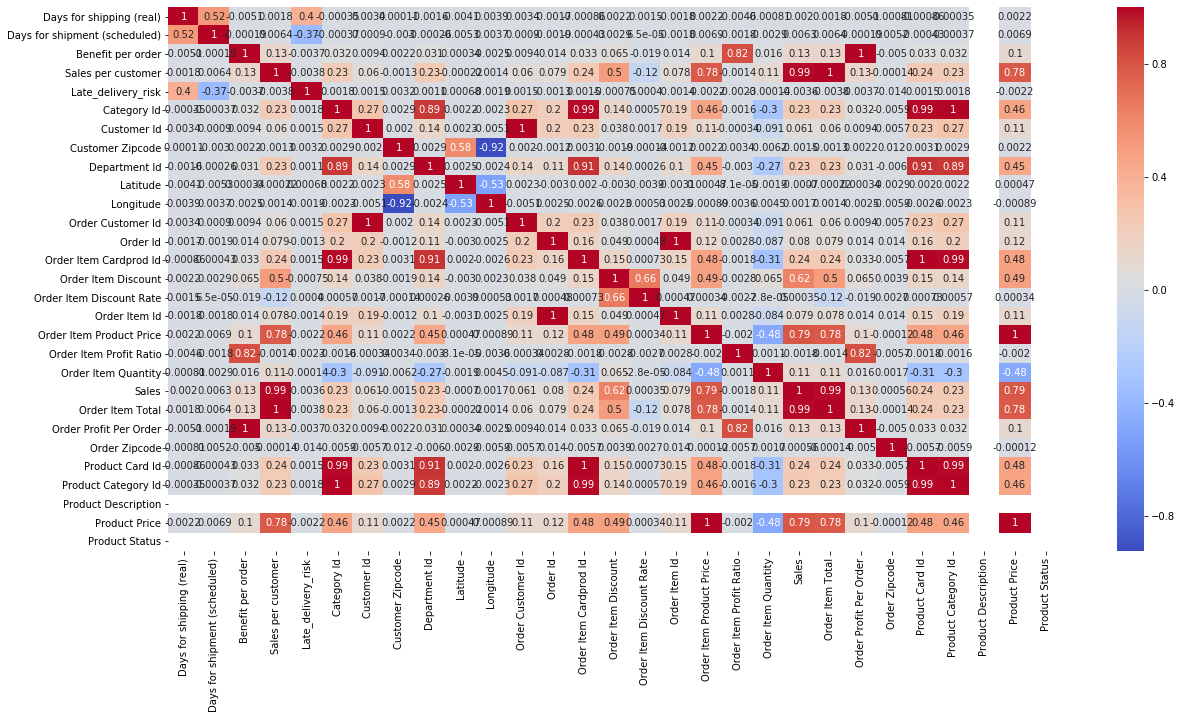

In [4]:
temp = dataset.isnull().sum()
dataset[['Customer Fname','Customer Lname']]
dataset['Customer Full Name'] = dataset['Customer Fname'] + dataset['Customer Lname']
dataset['Customer Full Name'].head()

dataset['Customer Zipcode'].value_counts()
dataset['Customer Zipcode'].isnull().sum()
dataset['Customer Zipcode'] = dataset['Customer Zipcode'].fillna(0)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,10))
sns.heatmap(dataset.corr(), annot=True, cmap='coolwarm')

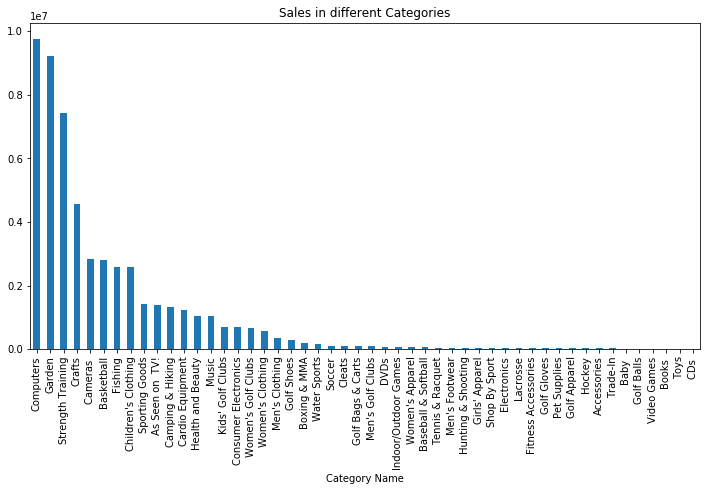

In [5]:
dataset['Market'].value_counts()
market = dataset.groupby('Market')
market['Sales per customer'].sum().sort_values(ascending=False).plot.bar(figsize=(12,6),title='Sales in different market')

region = dataset.groupby('Order Region')
region['Sales per customer'].sum().sort_values(ascending=False).plot.bar(figsize=(12,6),title='Sales in different region')

cat = dataset.groupby('Category Name')
cat['Sales per customer'].sum().sort_values(ascending=False).plot.bar(figsize=(12,6),title='Sales in different Categories')

cat['Sales per customer'].mean().sort_values(ascending=False).plot.bar(figsize=(12,6),title='Sales in different Categories')


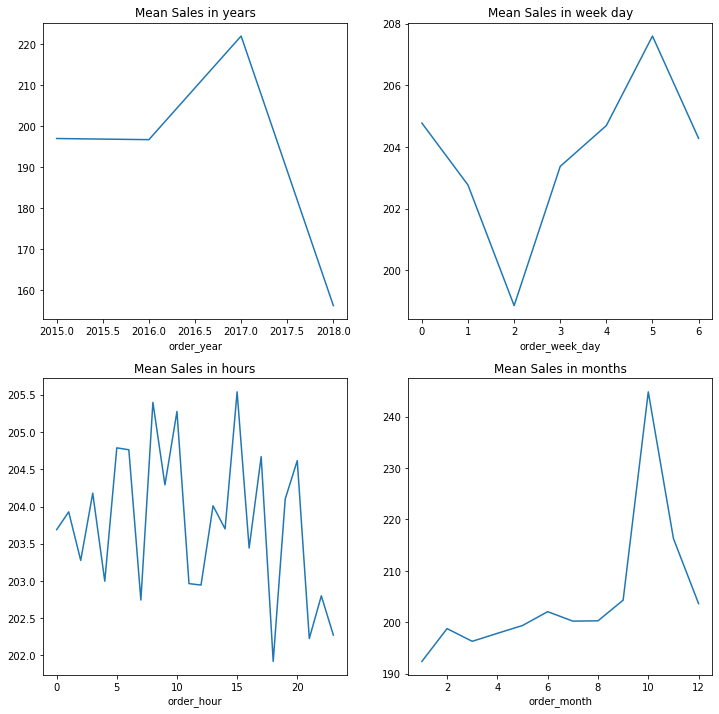

In [6]:
temp = pd.DatetimeIndex(dataset['order date (DateOrders)'])
temp

dataset['order_year'] = temp.year
dataset['order_month'] = temp.month
dataset['order_week_day'] = temp.weekday
dataset['order_hour'] = temp.hour
dataset['order_month_year'] = temp.to_period('M')
dataset[['order_year','order_month','order_week_day','order_hour','order_month_year']]

plt.figure(figsize=(10,20))

plt.subplot(2,2,1)
df_year = dataset.groupby('order_year')
df_year['Sales'].mean().plot(figsize=(12,12),title='Mean Sales in years')

plt.subplot(2,2,2)
df_day = dataset.groupby('order_week_day')
df_day['Sales'].mean().plot(figsize=(12,12),title='Mean Sales in week day')

plt.subplot(2,2,3)
df_hour = dataset.groupby('order_hour')
df_hour['Sales'].mean().plot(figsize=(12,12),title='Mean Sales in hours')

plt.subplot(2,2,4)
df_month = dataset.groupby('order_month')
df_month['Sales'].mean().plot(figsize=(12,12),title='Mean Sales in months')


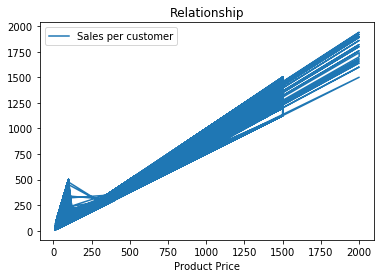

In [7]:
dataset.plot(x='Product Price',y='Sales per customer',title='Relationship')


In [10]:
dataset['order date (DateOrders)'] = pd.to_datetime(dataset['order date (DateOrders)'])

dataset['order date (DateOrders)'] .max()

Timestamp('2018-01-31 23:38:00')

In [11]:
import datetime
present = datetime.datetime(2018,2,1)
present

datetime.datetime(2018, 2, 1, 0, 0)

In [44]:
customer_seg = dataset.groupby('Order Customer Id').agg({'order date (DateOrders)': lambda x:(present-x.max()).days, \
                                                      'Order Id': lambda x:len(x), 'Sales': lambda x:x.sum()})
                                                     
customer_seg

,order date (DateOrders),Order Id,Sales
Order Customer Id,,,
1,792,1,499.950012
2,136,10,1819.730034
3,229,18,3537.680094
4,380,14,1719.630030
5,457,7,1274.750023
...,...,...,...
20753,0,1,215.820007
20754,0,1,215.820007
20755,0,1,327.750000


In [45]:
# quantile
quantiles = customer_seg.quantile(q=[0.25, 0.5, 0.75])

quantiles = quantiles.to_dict()

quantiles

{'order date (DateOrders)': {0.25: 75.0, 0.5: 159.0, 0.75: 307.0},
 'Order Id': {0.25: 1.0, 0.5: 7.0, 0.75: 15.0},
 'Sales': {0.25: 293.0400085, 0.5: 1499.82503324, 0.75: 2915.8800654175}}

In [46]:
#R_value越小越好
def R_Score(a,b,c):
    if a <= c[b][0.25]:
        return 4
    if a <= c[b][0.50]:
        return 3
    if a <= c[b][0.75]:
        return 2
    return 1

def FM_Score(a,b,c):
    if a <= c[b][0.25]:
        return 1
    if a <= c[b][0.50]:
        return 2
    if a <= c[b][0.75]:
        return 3
    return 4

In [47]:
customer_seg.rename(columns={'order date (DateOrders)': 'R_Value',
                             'Order Id': 'F_Value', 'Sales':'M_Value'}, inplace=True)

customer_seg

,R_Value,F_Value,M_Value
Order Customer Id,,,
1,792,1,499.950012
2,136,10,1819.730034
3,229,18,3537.680094
4,380,14,1719.630030
5,457,7,1274.750023
...,...,...,...
20753,0,1,215.820007
20754,0,1,215.820007
20755,0,1,327.750000


In [48]:
# quantile
quantiles = customer_seg.quantile(q=[0.25, 0.5, 0.75])

quantiles = quantiles.to_dict()

quantiles

{'R_Value': {0.25: 75.0, 0.5: 159.0, 0.75: 307.0},
 'F_Value': {0.25: 1.0, 0.5: 7.0, 0.75: 15.0},
 'M_Value': {0.25: 293.0400085, 0.5: 1499.82503324, 0.75: 2915.8800654175}}

In [49]:
customer_seg['R_Score']= customer_seg['R_Value'].apply(R_Score, args=('R_Value', quantiles))
customer_seg['F_Score']= customer_seg['F_Value'].apply(FM_Score, args=('F_Value', quantiles))
customer_seg['M_Score']= customer_seg['M_Value'].apply(FM_Score, args=('M_Value', quantiles))

customer_seg

,R_Value,F_Value,M_Value,R_Score,F_Score,M_Score
Order Customer Id,,,,,,
1,792,1,499.950012,1,1,2
2,136,10,1819.730034,3,3,3
3,229,18,3537.680094,2,4,4
4,380,14,1719.630030,1,3,3
5,457,7,1274.750023,1,2,2
...,...,...,...,...,...,...
20753,0,1,215.820007,4,1,1
20754,0,1,215.820007,4,1,1
20755,0,1,327.750000,4,1,2


In [50]:
# RFM
def RFM_User(df):
    if df['M_Score'] > 2 and df['F_Score']>2 and df['R_Score']>2:
        return '重要价值用户'
    if df['M_Score']>2 and df['F_Score']<=2 and df['R_Score']>2:
        return '重要发展用户'
    if df['M_Score']>2 and df['F_Score']>2 and df['R_Score']<=2:
        return '重要保持用户'
    if df['M_Score']>2 and df['F_Score']<=2 and df['R_Score']<=2:
        return '重要挽留用户'
    
    if df['M_Score'] <= 2 and df['F_Score']>2 and df['R_Score']>2:
        return '一般价值用户'
    if df['M_Score']<=2 and df['F_Score']<=2 and df['R_Score']>2:
        return '一般发展用户'
    if df['M_Score']<=2 and df['F_Score']>2 and df['R_Score']<=2:
        return '一般保持用户'
    if df['M_Score']<=2 and df['F_Score']<=2 and df['R_Score']<=2:
        return '一般挽留用户'
    

In [51]:
customer_seg['Custonmer_Segmentation'] = customer_seg.apply(RFM_User,axis=1)
customer_seg

,R_Value,F_Value,M_Value,R_Score,F_Score,M_Score,Custonmer_Segmentation
Order Customer Id,,,,,,,
1,792,1,499.950012,1,1,2,一般挽留用户
2,136,10,1819.730034,3,3,3,重要价值用户
3,229,18,3537.680094,2,4,4,重要保持用户
4,380,14,1719.630030,1,3,3,重要保持用户
5,457,7,1274.750023,1,2,2,一般挽留用户
...,...,...,...,...,...,...,...
20753,0,1,215.820007,4,1,1,一般发展用户
20754,0,1,215.820007,4,1,1,一般发展用户
20755,0,1,327.750000,4,1,2,一般发展用户


In [52]:
dataset['Type'].value_counts()

DEBIT       69295
TRANSFER    49883
PAYMENT     41725
CASH        19616
Name: Type, dtype: int64

In [55]:
pay_type1 = dataset[dataset['Type']=='DEBIT']
pay_type2 = dataset[dataset['Type']=='TRANSFER']
pay_type3 = dataset[dataset['Type']=='PAYMENT']
pay_type4 = dataset[dataset['Type']=='CASH']
pay_type1.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Product Price,Product Status,shipping date (DateOrders),Shipping Mode,Customer Full Name,order_year,order_month,order_week_day,order_hour,order_month_year
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,327.75,0,2/3/2018 22:56,Standard Class,CallyHolloway,2018,1,2,22,2018-01
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,327.75,0,1/16/2018 11:45,Standard Class,TanaTate,2018,1,5,11,2018-01
6,DEBIT,2,1,95.180000,288.420013,Late delivery,1,73,Sporting Goods,Caguas,...,327.75,0,1/15/2018 10:42,First Class,ConstanceTerrell,2018,1,5,10,2018-01
13,DEBIT,2,1,24.580000,245.809998,Late delivery,1,73,Sporting Goods,Caguas,...,327.75,0,1/15/2018 8:15,First Class,NatalieMcfadden,2018,1,5,8,2018-01
15,DEBIT,2,1,-259.579987,324.470001,Late delivery,1,73,Sporting Goods,Caguas,...,327.75,0,1/15/2018 7:33,First Class,SadeLancaster,2018,1,5,7,2018-01


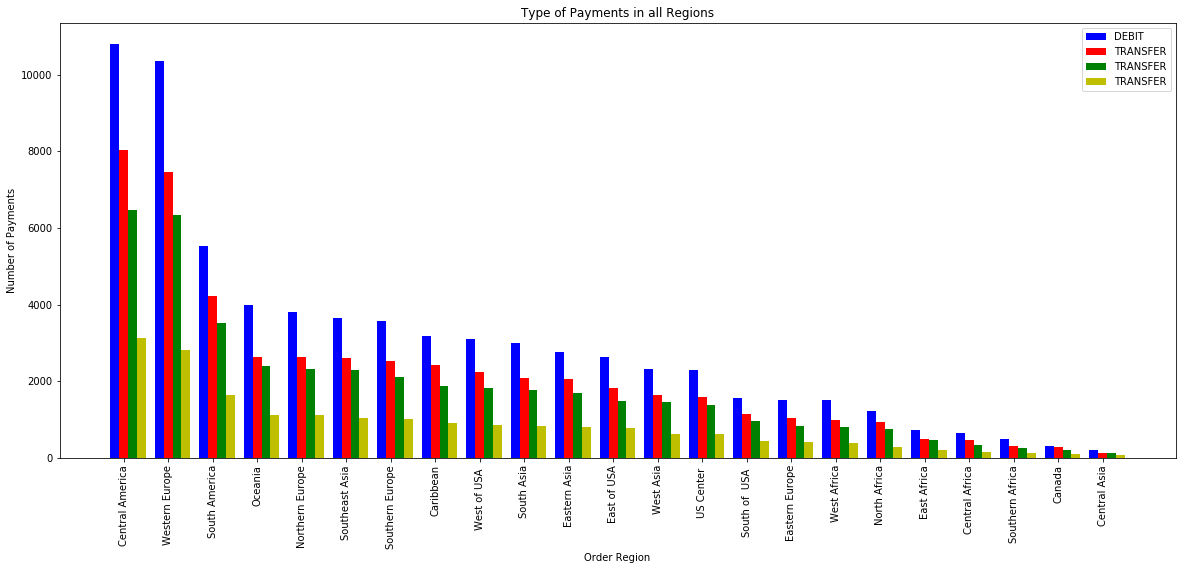

In [66]:
count1 = pay_type1['Order Region'].value_counts()
count2 = pay_type2['Order Region'].value_counts()
count3 = pay_type3['Order Region'].value_counts()
count4 = pay_type4['Order Region'].value_counts()
count1.head()

region_num = len(count1)

fig,ax = plt.subplots(figsize=(20,8))
index = np.arange(region_num)
bar_width=0.2

type1 = plt.bar(index,count1,bar_width, color='b',label='DEBIT')
type2 = plt.bar(index+bar_width,count2,bar_width, color='r',label='TRANSFER')
type3 = plt.bar(index+2*bar_width,count3,bar_width, color='g',label='TRANSFER')
type4 = plt.bar(index+3*bar_width,count4,bar_width, color='y',label='TRANSFER')
plt.xlabel('Order Region')
plt.ylabel('Number of Payments')
plt.title('Type of Payments in all Regions')
plt.legend()

#
names = dataset['Order Region'].value_counts().keys()
plt.xticks(index+bar_width, names, rotation='vertical')
plt.show()

# conclusion
Debit储蓄是所有地区中使用最多的支付方式

Cash现金是所有地区中使用最少的支付方式

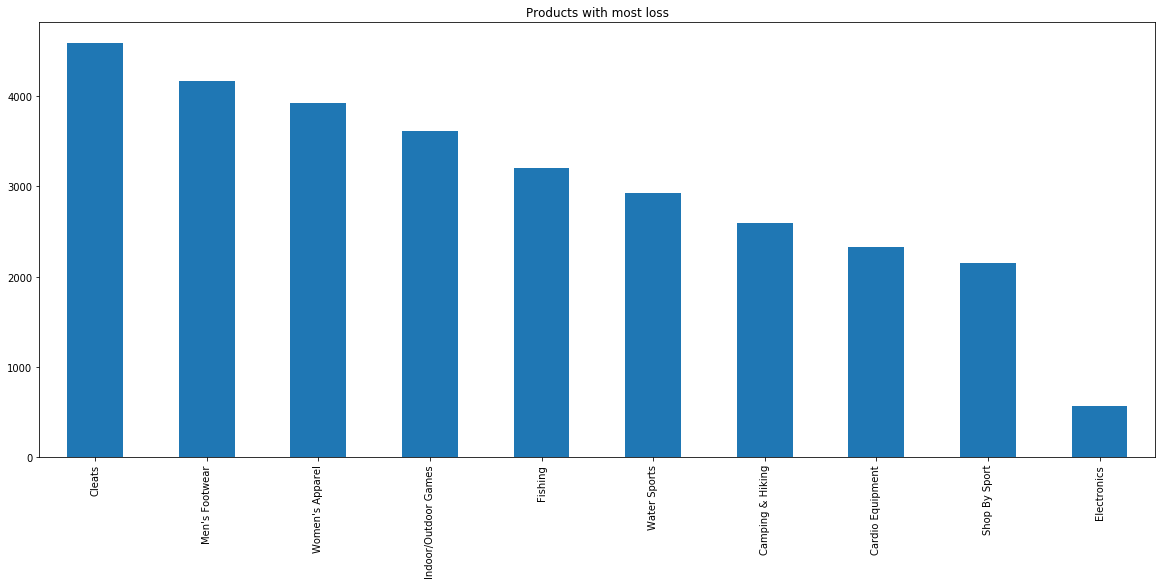

In [68]:
loss = dataset[dataset['Benefit per order']<0]

loss['Category Name'].value_counts().nlargest(10).plot.bar(figsize=(20,8),title='Products with most loss')

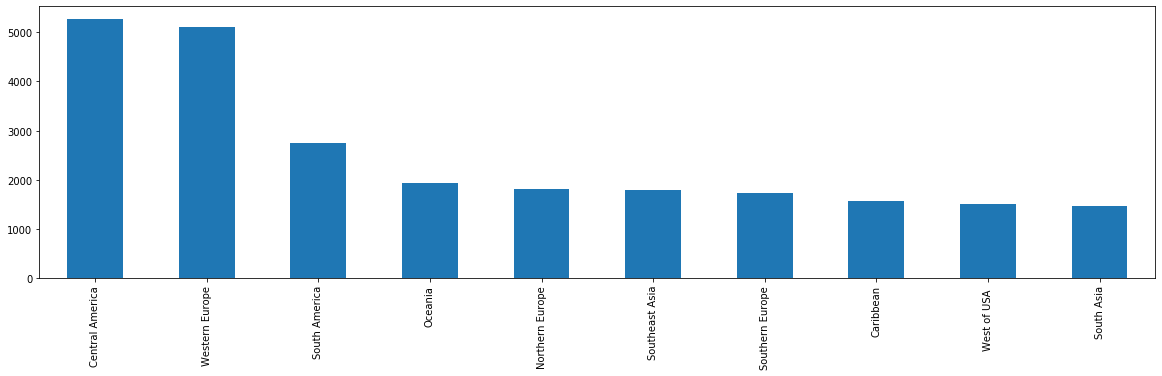

In [69]:
loss['Order Region'].value_counts().nlargest(10).plot.bar(figsize=(20,5))

In [70]:
print('总损失:', loss['Benefit per order'].sum())

总损失: -3883547.345768667


In [72]:
dataset['Order Status'].value_counts()

COMPLETE           59491
PENDING_PAYMENT    39832
PROCESSING         21902
PENDING            20227
CLOSED             19616
ON_HOLD             9804
SUSPECTED_FRAUD     4062
CANCELED            3692
PAYMENT_REVIEW      1893
Name: Order Status, dtype: int64

In [74]:
dataset[dataset['Order Status'] == 'SUSPECTED_FRAUD']['Type'].value_counts()

TRANSFER    4062
Name: Type, dtype: int64

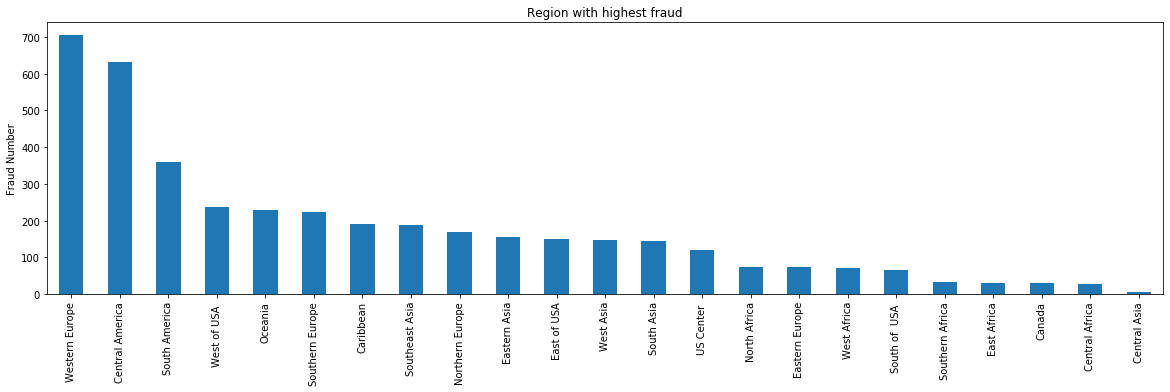

In [77]:
# 不同地区欺诈交易情况
high_fraud = dataset[dataset['Order Status'] == 'SUSPECTED_FRAUD']
high_fraud['Order Region'].value_counts().plot.bar(figsize=(20,5))
plt.title('Region with highest fraud')
plt.ylabel('Fraud Number')
plt.show()

Text(0.5, 1.0, 'Top 10 in Western Europe')

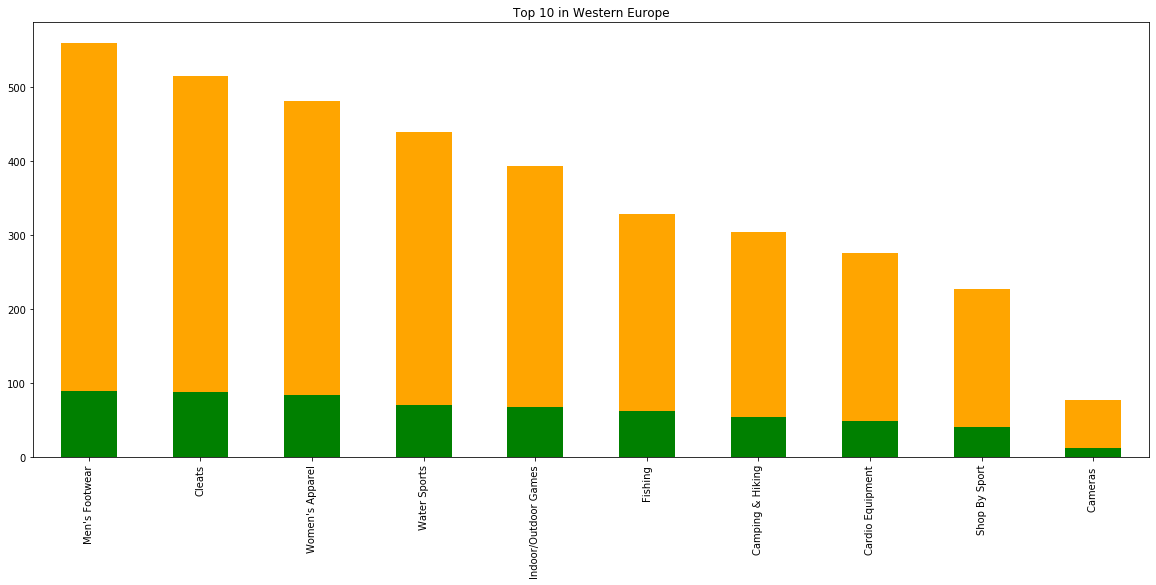

In [83]:
high_fraud_total = dataset[dataset['Order Status'] == 'SUSPECTED_FRAUD']
high_fraud_we = dataset[(dataset['Order Status'] == 'SUSPECTED_FRAUD') & (dataset['Order Region'] == 'Western Europe')]

fraund1 = high_fraud_total['Category Name'].value_counts().nlargest(10).plot.bar(figsize=(20,8),title='Fraud Category',color='orange')
fraund2 = high_fraud_we['Category Name'].value_counts().nlargest(10).plot.bar(figsize=(20,8),title='Fraud Category in Western Europe',color='green')
plt.title('Top 10 in Western Europe')

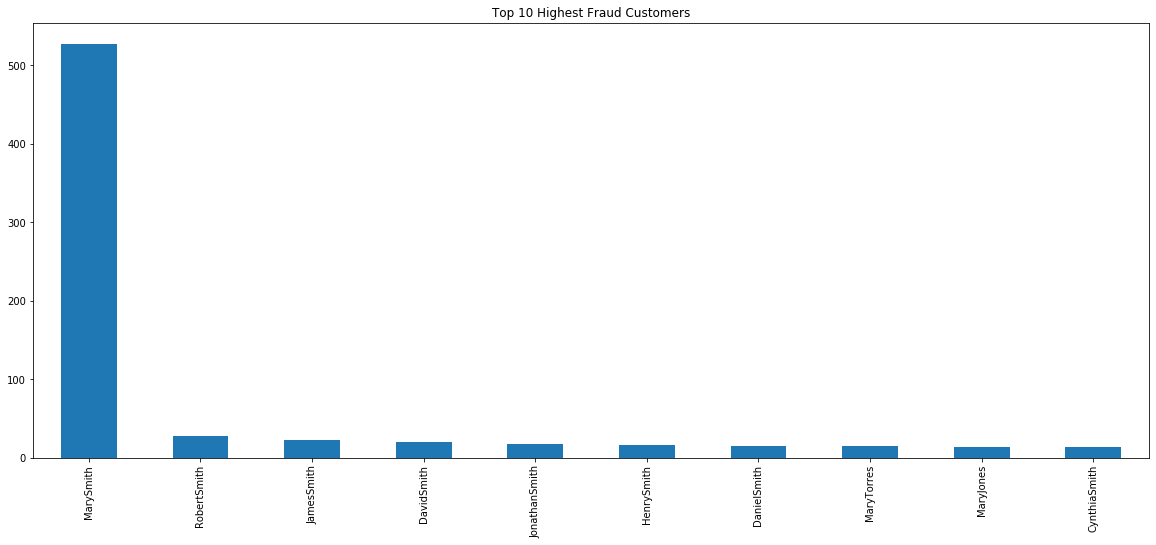

In [84]:
cus = dataset[dataset['Order Status']=='SUSPECTED_FRAUD']
cus['Customer Full Name'].value_counts().nlargest(10).plot.bar(figsize=(20,8),title='Top 10 Highest Fraud Customers')

In [88]:
print(dataset[dataset['Customer Full Name']=='MarySmith']['Sales'].sum())
print(dataset[(dataset['Customer Full Name']=='MarySmith') & (dataset['Order Status']=='SUSPECTED_FRAUD')]['Sales'].sum())

4771645.883297398
102491.66191043999


In [90]:
import pickle
with open('data.pkl','wb') as file:
    pickle.dump(dataset, file)